In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import fiona
import rasterio
from rasterio.mask import mask
import json
from pprint import pprint
from scipy.misc import bytescale
from skimage import exposure
from matplotlib.colors import BoundaryNorm

%matplotlib inline

# define a function to add a colorbar of nice height
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)

## Landsat 8 OLI

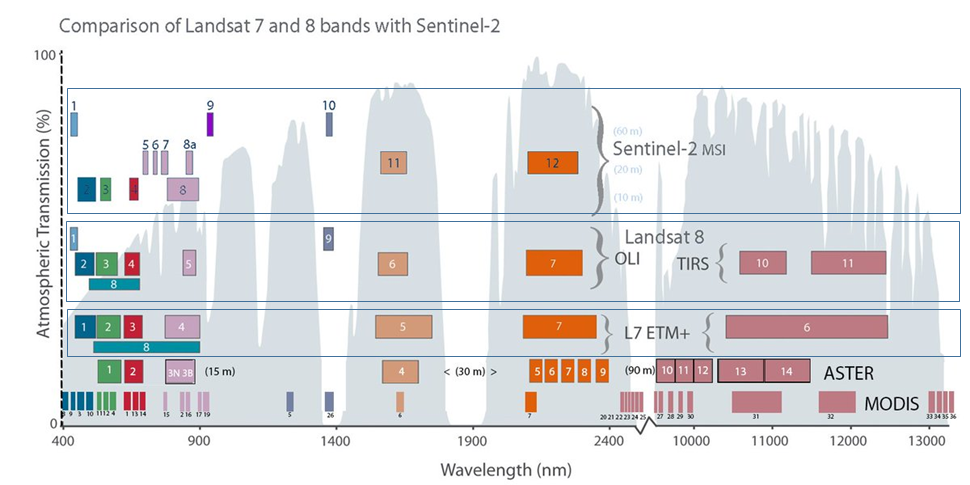

In [ ]:
## we will pick a scene over the front range. Check out the files in the folder on AWS
aws_scene_path = 'landsat-pds/c1/L8/034/032/LC08_L1TP_034032_20180526_20180605_01_T1'
!aws s3 ls $aws_scene_path/ --no-sign-request

# since we don't have AWSCLI configured, we will need to download the data before we can load it.

In [ ]:
scene_base = os.path.basename(aws_scene_path) # all after last slash
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'] # need these for the file paths

# specify an output directory to hold the files. create it if it doesn't exist
L8_dir = @@@@@@ # specify a directory, such as 'data_L8'
if not os.path.exists(L8_dir):
    os.mkdir(L8_dir)

# iterate through the bands list to download the data
for band in bands:
    sample_band = aws_scene_path + '/{}_{}.TIF'.format(scene_base, band)
    s3_path = "s3://{}".format(sample_band)
    print(s3_path)
    
    # copy from S3 if not done already
    if not os.path.exists(L8_dir + '/{}_{}.TIF'.format(scene_base, band)):
        !aws s3 cp $s3_path $L8_dir --no-sign-request
    

# also get the json file, to view the metadata

In [ ]:
# download the JSON file if it doesn't exist already
json_path = 's3://' + aws_scene_path + '/{}_MTL.json'.format(scene_base)

if not os.path.exists(L8_dir + '/{}_MTL.json'.format(scene_base)):
    !aws s3 cp $json_path $L8_dir --no-sign-request

In [ ]:
# load the file
local_mtl = L8_dir + '/{}_MTL.json'.format(scene_base)

with open(local_mtl, 'r') as f:
    mtl = json.load(f)
    
# show it with pretty print    
pprint(mtl)

# now that the GeoTIFFs are downloaded, load them into a raster stack
We will subset it by an AOI

In [ ]:
# this code reads in the geometry attribute for the AOI
shp = "shp/aoi.shp"
shp = "shp/aoi_granby.shp"
with fiona.open(shp, "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

# we will read in the images band by band and subset it by the AOI
band_arrs = [] # empty list to store the data arrays
for band in bands:
    sample_band = L8_dir + '/{}_{}.TIF'.format(scene_base, band)
    with rasterio.open(sample_band, 'r') as src:
        arr, prof = mask(src, geoms, crop=True)
        
        
    band_arrs.append(arr.squeeze()) # use the .squeeze() method to remove singleton dimension
    
# then convert to numpy array, and delete the list
arr_L8 = @@@@@@ #call to convert bad_arrs to a numpy array
del band_arrs

# print the shape of the full array
print('Image Dimensions: {}'.format(arr_L8.shape))

In [ ]:
# take a look at the Affine transform for the cropped image
print(prof)
prof

In [ ]:
# get the extent of the image
xmin = prof.c
ymin = prof.f + prof.e*arr_L8.shape[1] # rows
xmax = prof.c + prof.a*arr_L8.shape[2] # columns
ymax = prof.f
extent = [xmin, ymin, xmax, ymax]

In [ ]:
# slice the full array for RGB channels
cir = @@@@@@ # use a list to specify the bands for nir-red-green
rgb = @@@@@@ # use a list to specify the bands for red-green-blue
rgb_arr = arr_L8[@@@@@@, :, :] # choose a combination for color composite
rgb_arr = np.rollaxis(rgb_arr, 0, 3) # need channel axis to be last for plotting
rgb_arr_ma = np.ma.masked_equal(rgb_arr, 0)

# plot the image
fig, ax = plt.subplots(figsize=(20,20))
plt.title('Landsat 8 Color Composite')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.imshow(bytescale(rgb_arr), extent=extent, interpolation='nearest');

# Let's take a look at the individual bands. There may not be good contrast in some of the bands so we will also apply contrast stretching to the bands.

In [ ]:
# plot the bands
plt.figure(figsize=(20,10))
channels = ['Coastal', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'] # used for plot titles
for i in range(arr_L8.shape[0]):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plot_band = np.ma.masked_equal(arr_L8[i], 0)
    plt.imshow(plot_band, cmap="Greys_r", interpolation='nearest')
    plt.title(channels[i])
plt.show()

In [ ]:
# plot it again with contrast enhancement
plt.figure(figsize=(20,10))
for i in range(arr_L8.shape[0]):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plot_band = np.ma.masked_equal(arr_L8[i], 0)
    
    # contrast enhancement
    p2, p98 = @@@@@@ # use np.percentile to find the (2 and 98) percent values in the plot_band
    img_rescale = @@@@@@ # use exposure.rescale_intensity to adjust the plot_band, specifying the correct value for in_range
    
    # display
    plt.imshow(img_rescale, cmap="Greys_r", interpolation='nearest')
    plt.title(channels[i])
plt.show()

## Feature Engineering: Vegetation Index and Chromaticity

Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs). The equation we will be using to calculate NDVI is:

\begin{equation*}
NDVI = \frac{NIR - RED}{NIR + RED}
\end{equation*}


Chromaticity is an objective specification of the quality of a color regardless of its luminance. In other words, it can be invariant to illumination conditions. Here we specify the Blue, Green, Red, and NIR channels as colors to calculate their chromaticity.

\begin{equation*}
blue_{chromaticity} = \frac{BLUE}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
green_{chromaticity} = \frac{GREEN}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
red_{chromaticity} = \frac{RED}{BLUE + GREEN + RED + NIR}
\end{equation*}

\begin{equation*}
nir_{chromaticity} = \frac{NIR}{BLUE + GREEN + RED + NIR}
\end{equation*}

In [ ]:
# subset the bands as necessary
blue = @@@@@@ # slice the arr_L8 array to get the blue band
green = @@@@@@ # slice the arr_L8 array to get the blue band
red = @@@@@@ # slice the arr_L8 array to get the blue band
nir = @@@@@@ # slice the arr_L8 array to get the blue band

# mask them
blue = np.ma.masked_equal(blue,0)
red = np.ma.masked_equal(red,0)
nir = np.ma.masked_equal(nir,0)

# define NDVI..  look at some stats
ndvi = @@@@@@ # code the equation for ndvi
print('ndvi min/max: {} / {}'.format(ndvi.min(), ndvi.max()))

# define a chromaticity coordinate..  look at some stats
c_red = @@@@@@ # code the equation for red chromaticity coordinate
print('c_red min/max: {} / {}'.format(c_red.min(), c_red.max()))

# plot the NDVI image
fig, ax = plt.subplots(figsize=(10,10))
cf = ax.imshow(ndvi) # change cmap
ax.set_title('NDVI')
colorbar(cf)
plt.show()

# plot the red chromaticity image
fig, ax = plt.subplots(figsize=(10,10))
cf = ax.imshow(c_red) # change cmap
ax.set_title('Chromaticity - Red')
colorbar(cf)
plt.show()


# Application: Unsupervised classification using K-Means clustering

We will use [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to examine unsupervised classification:

* original 7 Landsat 8 OLI bands [Coastal, Blue, Green, Red, NIR, SWIR-1, SWIR-2]
* chromaticity [Blue, Green, Red, and NIR]
* de-meaned Landsat 8 OLI bands [Coastal, Blue, Green, Red, NIR, SWIR-1, SWIR-2]


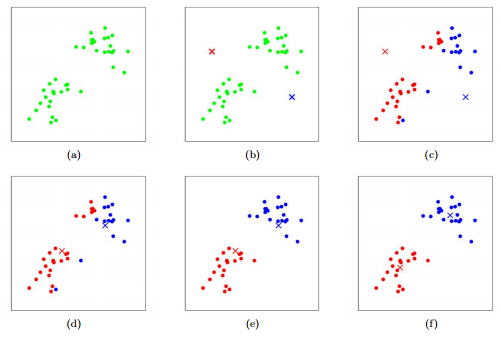
http://stanford.edu/~cpiech/cs221/handouts/kmeans.html

#### K-Means on original 7 Landsat 8 OLI bands

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# define number of clusters and create classifier
n_clusters = 6
clf = @@@@@@ # create a KMeans classifier with n_clusters as specified and random_state=0

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(arr_L8, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# fit the classifier
labels_test_im = clf.fit_predict(X, y=None)

# reshape the labels to the image size
labels_test_im_arr = np.reshape(labels_test_im, (arr_L8.shape[1], arr_L8.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
cf = ax[0].imshow(labels_test_im_arr, extent=extent, interpolation='nearest')
colorbar(cf)
ax[0].set_title('K-Means (k={}) on Landsat 8 bands'.format(n_clusters))
ax[0].set_xlabel('Easting')
ax[0].set_ylabel('Northing')
ax[1].imshow(bytescale(rgb_arr), extent=extent, interpolation='nearest')
ax[1].set_title('Color Composite')
ax[1].set_xlabel('Easting')
ax[1].set_ylabel('Northing')
plt.show()

#### K-Means on chromaticity [Blue, Green, Red, and NIR]

In [ ]:
# define number of clusters and create classifier
n_clusters = 6
clf = @@@@@@ # create a KMeans classifier with n_clusters as specified and random_state=0

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(arr_L8, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# use only the Blue/Green/Red/NIR channels
Xc = @@@@@@ # slice the reshaped array to get the Blue, Green, Red, and NIR channels. hint: channels are axis=1

# normalize by the sum to get chromaticity
Xc = @@@@@@ # hint: across channels is axis=0


# fit the classifier
labels_test_chrom = clf.fit_predict(Xc, y=None)

# reshape the labels to the image size
labels_test_chrom_arr = np.reshape(labels_test_chrom, (arr_L8.shape[1], arr_L8.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
cf = ax[0].imshow(labels_test_chrom_arr, interpolation='nearest', extent=extent)
colorbar(cf)
ax[0].set_title('K-Means (k={}) on Landsat 8 Chromaticity'.format(n_clusters))
ax[0].set_xlabel('Easting')
ax[0].set_ylabel('Northing')
ax[1].imshow(bytescale(rgb_arr), extent=extent, interpolation='nearest')
ax[1].set_title('Color Composite')
ax[1].set_xlabel('Easting')
ax[1].set_ylabel('Northing')
plt.show()

#### K-Means on de-meaned Landsat 8 OLI bands

In [ ]:
# define number of clusters and create classifier
n_clusters = 6
clf = @@@@@@ # create a KMeans classifier with n_clusters as specified and random_state=0

## fit the K-means classifier on the 7 Landsat bands
# first reshape the array so channels are last axis. 
im_reshape = np.rollaxis(arr_L8, 0, 3).astype('float32')

# reshape again into columns for each channel
X = im_reshape.reshape(-1, im_reshape.shape[-1])

# normalize by the mean and standard deviation
Xc = @@@@@@

# fit the classifier
labels_test_demean = clf.fit_predict(Xc, y=None)

# reshape the labels to the image size
labels_test_demean_arr = np.reshape(labels_test_demean, (arr_L8.shape[1], arr_L8.shape[2]))

## show the result
fig, ax = plt.subplots(1,2, figsize = (20, 20))
cf = ax[0].imshow(labels_test_demean_arr, interpolation='nearest', extent=extent)
colorbar(cf)
ax[0].set_title('K-Means (k={}) on Landsat 8 de-meaned bands'.format(n_clusters))
ax[0].set_xlabel('Easting')
ax[0].set_ylabel('Northing')
ax[1].imshow(bytescale(rgb_arr), extent=extent, interpolation='nearest')
ax[1].set_title('Color Composite')
ax[1].set_xlabel('Easting')
ax[1].set_ylabel('Northing')
plt.show()

# BONUS: Let's look for a Sentinel-2 scene over the same AOI
## Sentinel-2 data has the following co-registered bands:
 
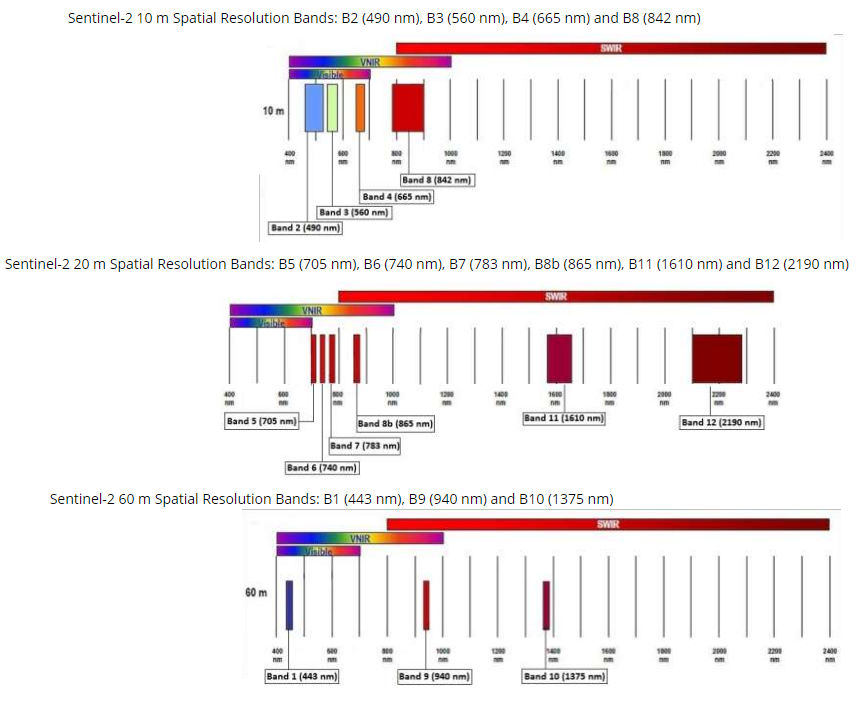

Sentinel-2 has co-registered bands at coarser resolutions (e.g., 20 and 60 meters), however, for this section we will only be using the 10 meter bands. 

The Sentinel-2 tile ID that intersects our AOI is 13TDE. The date of the Landsat scene acquisition is 2018-05-26, and the closest cloud-free Sentinel-2 scene was captured on 2018-06-01.

In [ ]:
# Take a look at the folder for this scene on AWS
!aws s3 ls sentinel-s2-l1c/tiles/13/T/DE/2018/6/1/0/ --no-sign-request

In [ ]:
# create a directory to hold the sentinel2 data if it doesn't exist already
if not os.path.exists('sentinel2'):
    !mkdir sentinel2

In [ ]:
# only download the 10 meter bands, 2 3 4 8
sbands = [2,3,4,8]
aws_sent = 'sentinel-s2-l1c/tiles/13/T/DE/2018/5/17/0/'
for b in sbands:
    band = 'B0{}.jp2'.format(b)
    out_path = 'sentinel2/{}'.format(band)
    if not os.path.exists(out_path):
        !aws s3 cp s3://$aws_sent$band $out_path --no-sign-request


In [ ]:
# check out some of the metadata from one of the Sentinel-2 bands
with rasterio.open(out_path) as src:
    print(src.meta)
    print(src.crs)
    print(src.bounds)

###### open the Sentinel-2 image and subset by the same AOI

In [ ]:
#read in the sentinel 2 bands
s_arr = []
for b in sbands:
    
    # construct the filename
    band = 'B0{}.jp2'.format(b)
    out_path = 'sentinel2/{}'.format(band)
    
    with rasterio.open(out_path) as src:
        arr, s_prof = mask(src, geoms, crop=True)
        
        s_arr.append(arr.squeeze())

# convert the list to a numpy array, then get rid of the list
arr_S2 = np.array(s_arr)
del s_arr

# see the shape of the numpy array
arr_S2.shape

In [ ]:
# take a look at the Affine transform for the cropped image
print(s_prof)
s_prof

In [ ]:
# get the extent of the image
s_xmin = s_prof.c
s_ymin = s_prof.f + s_prof.e*arr_S2.shape[1] # rows
s_xmax = s_prof.c + s_prof.a*arr_S2.shape[2] # columns
s_ymax = s_prof.f
s_extent = [xmin, ymin, xmax, ymax]

In [ ]:
# plot one of the Sentinel 2-m bands
plt.figure(figsize=(10,10))
s2_band = arr_S2[0]
p2, p98 = np.percentile(s2_band, (2,98) )
s2_plot_im = exposure.rescale_intensity(s2_band, (p2, p98))
plt.imshow(s2_plot_im, extent=s_extent, interpolation='nearest');